# Neural network from scratch to classify mnist digits

Jagyansis Jena
EE22M054

Importing basic Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## dataset

Few points about the dataset
1. The datset I am downloading is in csv format where column 1 is the label of the image.
2. The rest 784 columns signifies the image pixels
3. The readline command stores each of line which corresponds to a digit in list

In [ ]:
train_file = open(r"/content/drive/MyDrive/mnist_train.csv", 'r')
train_list = train_file.readlines()
train_file.close()

In [ ]:
train_list =train_list[1:] # done to avoid header line

In [ ]:
len(train_list) # length of the list It means 60000 training examples

60000

### Data Visualiztion

Here we to see the digits. I have plotted a $ 5 \times 5 $ subplots and then chosen a random index then splitted and resized it in the shape of (28,28).

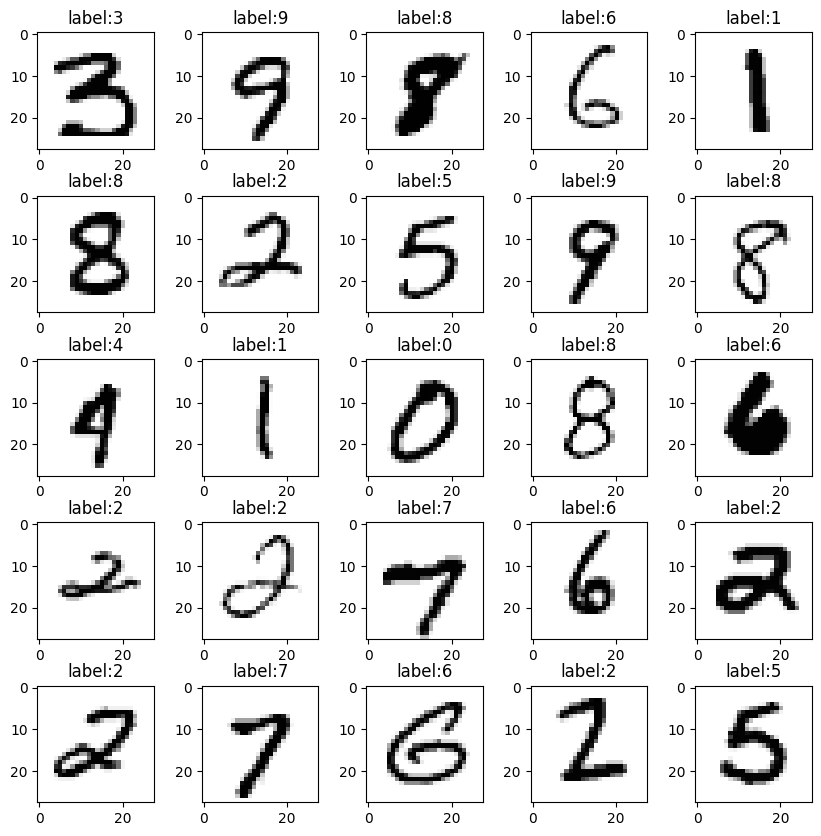

In [ ]:
import random
fig,ax = plt.subplots(5,5,figsize =(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(5):
    for j in range(5):
        all_values = train_list[random.randint(0,5000)].split(',')
        image_array = np.asfarray(all_values[1:]).reshape((28,28))
        ax[i][j].imshow(image_array, cmap='Greys', interpolation='None')
        ax[i][j].set_title(f"label:{all_values[0]}")


### test set

In [ ]:
test_file = open(r"/content/drive/MyDrive/mnist_test.csv", 'r')
test_list = test_file.readlines()
test_file.close()
test_list = test_list[1:]
len(test_list)

10000

### Required for confusion matrix display and classification report

In [ ]:
# I have stored the actual label in a list for using it later
import pandas as pd
test = pd.read_csv(r"/content/drive/MyDrive/mnist_test.csv")
actual_label = test.label
actual_label = actual_label.to_list()

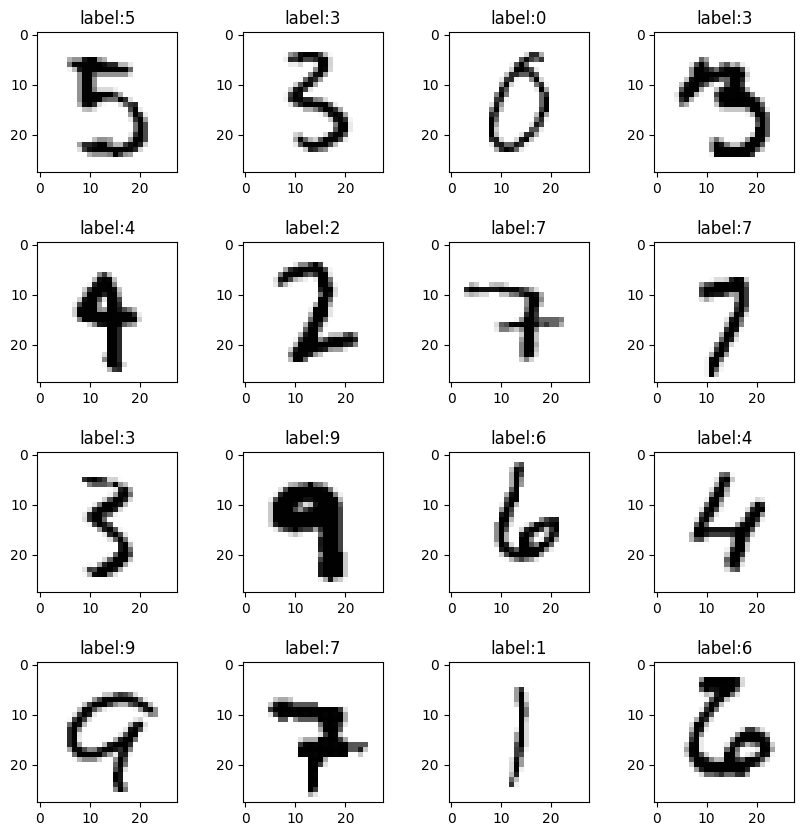

In [ ]:
fig,ax = plt.subplots(4,4,figsize =(10,10))
fig.subplots_adjust(hspace=0.5,wspace=0.3)   # visualization of Test set
for i in range(4):
    for j in range(4):
        all_values = test_list[random.randint(0,5000)].split(',')
        image_array = np.asfarray(all_values[1:]).reshape((28,28))
        ax[i][j].imshow(image_array, cmap='binary', interpolation='None')
        ax[i][j].set_title(f"label:{all_values[0]}")



# Deep Neural Network 1

**Silent features of the first neural network**
1. This neural network is not the baseline model we are given to implemnt. I am using it for comparison
2. The neural network is written in form of a class.
3. This neural network has one input layer 2 hidden layer and 1 output layer.
4. I am using sigmoid in hidden layer and softmax in output layer.

In [ ]:
class DNN1:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs   # hyperparameters of the neural network
    self.lr = lr

    # number of nodes in each layer
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    output_layer=self.sizes[3]
    # we are using a dictionary to store parameters of neural network
    # And for this neural network I am using a different intialization where i am randomizing it from normal values
    self.params = {
        'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
    }

    # defining activation functions and their derivatives
  def sigmoid(self, x, derivative=False):
      if derivative:
          return (np.exp(-x))/((np.exp(-x)+1)**2)
      return 1/(1 + np.exp(-x))
  def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)
  def forward_pass(self, x_train):
      ''' The forward pass to update parameters and activations.'''

      params = self.params

      # input layer activations becomes sample
      params['A0'] = x_train

      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.sigmoid(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.sigmoid(params['Z2'])

      # hidden layer 2 to output layer
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.softmax(params['Z3'])

      return params['A3']
  def backward_pass(self, y_train, output):
      '''
          This is the backpropagation algorithm, for calculating the updates
          of the neural network's parameters. '''


      params = self.params
      change_w = {}

      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w
  def update_network_parameters(self, changes_to_w):
      '''
          Update network parameters according to update rule from
          Stochastic Gradient Descent.

          θ = θ - η * ∇J(x, y),
              theta θ:            a network parameter (e.g. a weight w)
              eta η:              the learning rate
              gradient ∇J(x, y):  the gradient of the objective function,
                                  i.e. the change for a specific theta θ
      '''

      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value
  def compute_accuracy(self, test_data, output_nodes):
      '''
          This function does a forward pass of x, then checks if the indices
          of the maximum value in the output equals the indices in the label
          y. Then it sums over each prediction and calculates the accuracy.
      '''
      predictions = []
      all_predictions = []


      for x in test_data:
          all_values = x.split(',')
          # scale and shift the inputs
          inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
          # create the target output values (all 0.01, except the desired label which is 0.99)
          targets = np.zeros(output_nodes) + 0.01
          # all_values[0] is the target label for this record
          targets[int(all_values[0])] = 0.99
          output = self.forward_pass(inputs)
          pred = np.argmax(output)
          predictions.append(pred == np.argmax(targets))
          all_predictions.append(pred)

      return np.mean(predictions),all_predictions # returns prediction and accuracy
  def train(self, train_list, test_list, output_nodes):
        acc = []
        pred_for =[]
        start_time = time.time()
        for iteration in range(self.epochs):
          for x in train_list:
              all_values = x.split(',')
              # scale and shift the inputs
              inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
              # create the target output values (all 0.01, except the desired label which is 0.99)
              targets = np.zeros(output_nodes) + 0.01  # soft labeling
              # all_values[0] is the target label for this record
              targets[int(all_values[0])] = 0.99
              output = self.forward_pass(inputs)
              changes_to_w = self.backward_pass(targets, output)
              self.update_network_parameters(changes_to_w)

          accuracy, _ = self.compute_accuracy(test_list, output_nodes)

          acc.append(accuracy)
          print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
              iteration+1, time.time() - start_time, accuracy * 100
          ))
        _,all_pred = self.compute_accuracy(test_list,output_nodes) # taking the final epoch prediction as output
        pred_for.extend(all_pred)
        return acc,pred_for




In [ ]:
dnn = DNN1(sizes=[784, 128, 64,10], epochs=15,lr=0.01)
accc,pred = dnn.train(train_list, test_list, 10) # Training for 15 epoches and learning rate 0.01

Epoch: 1, Time Spent: 64.92s, Accuracy: 54.72%
Epoch: 2, Time Spent: 130.97s, Accuracy: 61.25%
Epoch: 3, Time Spent: 195.20s, Accuracy: 65.10%
Epoch: 4, Time Spent: 261.49s, Accuracy: 68.91%
Epoch: 5, Time Spent: 324.95s, Accuracy: 73.57%
Epoch: 6, Time Spent: 388.17s, Accuracy: 76.86%
Epoch: 7, Time Spent: 454.90s, Accuracy: 78.46%
Epoch: 8, Time Spent: 518.49s, Accuracy: 77.09%
Epoch: 9, Time Spent: 585.98s, Accuracy: 73.31%
Epoch: 10, Time Spent: 650.65s, Accuracy: 73.71%
Epoch: 11, Time Spent: 715.76s, Accuracy: 75.00%
Epoch: 12, Time Spent: 783.46s, Accuracy: 76.26%
Epoch: 13, Time Spent: 851.16s, Accuracy: 77.62%
Epoch: 14, Time Spent: 917.07s, Accuracy: 78.58%
Epoch: 15, Time Spent: 980.92s, Accuracy: 79.28%


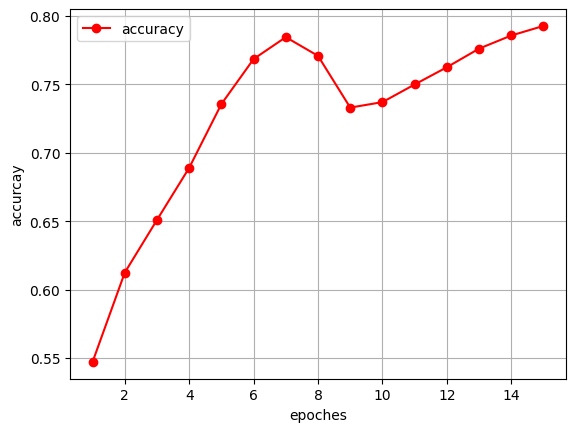

In [ ]:
epoches = [x for x in range(1,16)]
plt.plot(epoches,accc,'ro-',label ='accuracy')
plt.xlabel('epoches')
plt.ylabel('accurcay')
plt.grid()
plt.legend()


Text(0.5, 0.98, 'Confusion Matrix')

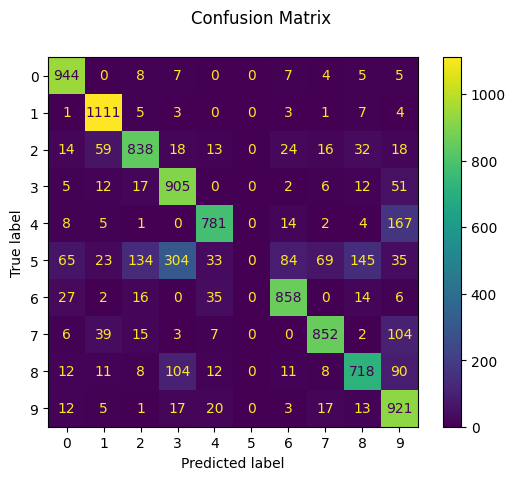

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(actual_label, pred)
disp.figure_.suptitle("Confusion Matrix")



In [ ]:
accuracy_score(actual_label, pred)

0.7928

In [ ]:
print(classification_report(actual_label,pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       980
           1       0.88      0.98      0.93      1135
           2       0.80      0.81      0.81      1032
           3       0.66      0.90      0.76      1010
           4       0.87      0.80      0.83       982
           5       0.00      0.00      0.00       892
           6       0.85      0.90      0.87       958
           7       0.87      0.83      0.85      1028
           8       0.75      0.74      0.75       974
           9       0.66      0.91      0.76      1009

    accuracy                           0.79     10000
   macro avg       0.72      0.78      0.75     10000
weighted avg       0.73      0.79      0.76     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Observations


1.   The model is learning at a stedy rate as it is going from 54 for 80 percent accuracy.
2.   From the plot of accuracy we can see a decrease and increase in the model performance . This is due to instability issue of the code as large size matrix operations are taking place or maybe vanishing gradient problem.
3. The model is unable to recongnize 5 at all. we will fix this in the subsquent models






***

# Baseline DNN

**Silent features of the first neural network**
1. This neural network is the baseline model which we are given to implement.
2. The neural network is written in form of a class.
3. This neural network has one input layer 3 hidden layer and 1 output layer.
4. I am using sigmoid in hidden layer and softmax in output layer.

In [ ]:
class DNN2:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

    # number of nodes in each layer
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    hidden_3 = self.sizes[3]
    output_layer=self.sizes[4]

    self.params = {
        'W1':np.random.randn(hidden_1, input_layer),
        'W2':np.random.randn(hidden_2, hidden_1),
        'W3':np.random.randn(hidden_3, hidden_2),
        'W4':np.random.randn(output_layer,hidden_3)
    }

  def sigmoid(self, x, derivative=False):
      sig_x = 1/(1 + np.exp(-x))
      if derivative:
          return sig_x * (1 - sig_x)
      return sig_x

  def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)

  def forward_pass(self, x_train):
      params = self.params

      # input layer activations becomes sample
      params['A0'] = x_train

      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.sigmoid(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.sigmoid(params['Z2'])

      # hidden layer 2 to hidden layer 3
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.sigmoid(params['Z3'])

      # hidden layer 3 to output layer

      params['Z4'] = np.dot(params["W4"], params['A3'])
      params['A4'] = self.softmax(params['Z4'])

      return params['A4']
  def backward_pass(self, y_train, output):
      '''
          This is the backpropagation algorithm, for calculating the updates
          of the neural network's parameters.

          Note: There is a stability issue that causes warnings. This is
                caused  by the dot and multiply operations on the huge arrays.

                RuntimeWarning: invalid value encountered in true_divide
                RuntimeWarning: overflow encountered in exp
                RuntimeWarning: overflow encountered in square
      '''
      params = self.params
      change_w = {}

      # Calculate W4 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z4'], derivative=True)
      change_w['W4'] = np.outer(error, params['A3'])

      # Calculate W3 update
      error = np.dot(params['W4'].T, error) * self.sigmoid(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w
  def update_network_parameters(self, changes_to_w):
      '''
          Update network parameters according to update rule from
          Stochastic Gradient Descent.

          θ = θ - η * ∇J(x, y),
              theta θ:            a network parameter (e.g. a weight w)
              eta η:              the learning rate
              gradient ∇J(x, y):  the gradient of the objective function,
                                  i.e. the change for a specific theta θ
      '''

      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value
  def compute_accuracy(self, test_data, output_nodes):
      '''
          This function does a forward pass of x, then checks if the indices
          of the maximum value in the output equals the indices in the label
          y. Then it sums over each prediction and calculates the accuracy.
      '''
      predictions = []
      all_predictions = []


      for x in test_data:
          all_values = x.split(',')
          # scale and shift the inputs
          inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
          # create the target output values (all 0.01, except the desired label which is 0.99)
          targets = np.zeros(output_nodes) + 0.01
          # all_values[0] is the target label for this record
          targets[int(all_values[0])] = 0.99
          output = self.forward_pass(inputs)
          pred = np.argmax(output)
          predictions.append(pred == np.argmax(targets))
          all_predictions.append(pred)

      return np.mean(predictions),all_predictions
  def train(self, train_list, test_list, output_nodes):
        acc = []
        pred_for =[]
        start_time = time.time()
        for iteration in range(self.epochs):
          for x in train_list:
              all_values = x.split(',')
              # scale and shift the inputs
              inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
              # create the target output values (all 0.01, except the desired label which is 0.99)
              targets = np.zeros(output_nodes) + 0.01
              # all_values[0] is the target label for this record
              targets[int(all_values[0])] = 0.99
              output = self.forward_pass(inputs)
              changes_to_w = self.backward_pass(targets, output)
              self.update_network_parameters(changes_to_w)

          accuracy, _ = self.compute_accuracy(test_list, output_nodes)

          acc.append(accuracy)
          print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
              iteration+1, time.time() - start_time, accuracy * 100
          ))
        _,all_pred = self.compute_accuracy(test_list,output_nodes)
        pred_for.extend(all_pred)
        return acc,pred_for



In [ ]:
dnn = DNN2(sizes=[784, 500, 250,100,10], epochs=20, lr=0.01)
acc,predd = dnn.train(train_list, test_list, 10)

Epoch: 1, Time Spent: 236.08s, Accuracy: 36.28%
Epoch: 2, Time Spent: 455.00s, Accuracy: 49.23%
Epoch: 3, Time Spent: 670.39s, Accuracy: 59.21%
Epoch: 4, Time Spent: 893.37s, Accuracy: 65.96%
Epoch: 5, Time Spent: 1118.25s, Accuracy: 69.99%
Epoch: 6, Time Spent: 1353.08s, Accuracy: 72.74%
Epoch: 7, Time Spent: 1584.12s, Accuracy: 74.76%
Epoch: 8, Time Spent: 1823.17s, Accuracy: 76.45%
Epoch: 9, Time Spent: 2057.22s, Accuracy: 77.77%
Epoch: 10, Time Spent: 2282.91s, Accuracy: 79.09%
Epoch: 11, Time Spent: 2512.52s, Accuracy: 79.98%
Epoch: 12, Time Spent: 2747.13s, Accuracy: 80.61%
Epoch: 13, Time Spent: 2977.66s, Accuracy: 81.20%
Epoch: 14, Time Spent: 3209.50s, Accuracy: 81.87%
Epoch: 15, Time Spent: 3446.47s, Accuracy: 82.46%
Epoch: 16, Time Spent: 3688.33s, Accuracy: 82.85%
Epoch: 17, Time Spent: 3914.66s, Accuracy: 83.30%
Epoch: 18, Time Spent: 4153.60s, Accuracy: 83.68%
Epoch: 19, Time Spent: 4389.86s, Accuracy: 83.92%
Epoch: 20, Time Spent: 4630.83s, Accuracy: 84.17%


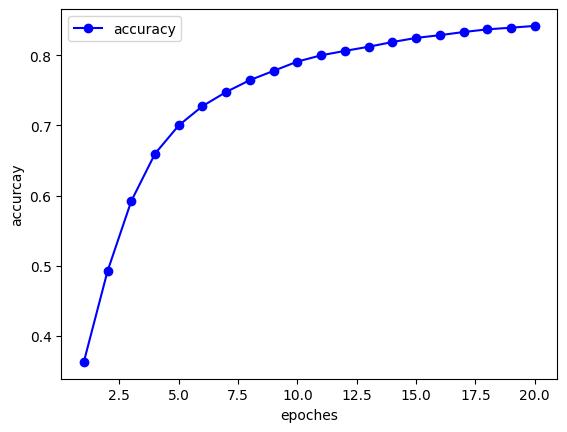

In [ ]:

epoches = [x for x in range(1,21)]
plt.plot(epoches,acc,'bo-',label ='accuracy')
plt.xlabel('epoches')
plt.ylabel('accurcay') # baseline model accuracy
plt.legend()


Text(0.5, 0.98, 'Confusion Matrix')

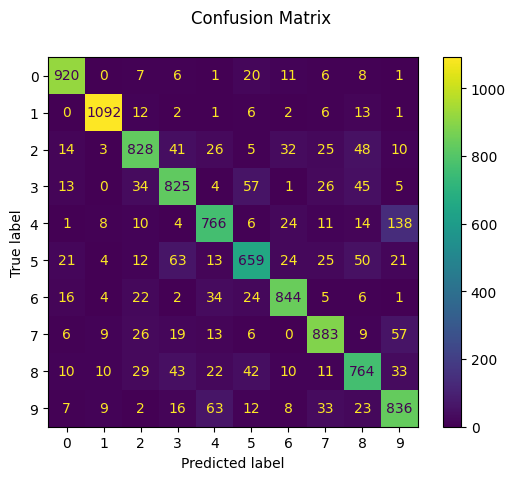

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(actual_label, predd)
disp.figure_.suptitle("Confusion Matrix")


In [ ]:
print(classification_report(actual_label,predd))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       980
           1       0.96      0.96      0.96      1135
           2       0.84      0.80      0.82      1032
           3       0.81      0.82      0.81      1010
           4       0.81      0.78      0.80       982
           5       0.79      0.74      0.76       892
           6       0.88      0.88      0.88       958
           7       0.86      0.86      0.86      1028
           8       0.78      0.78      0.78       974
           9       0.76      0.83      0.79      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Observations in the baseline model


1.   We can see a clear sign of convergence in the baseline model
2.   The model is able to classify digit 5 correctly which was not adressed by the 2 hidden layered model
3. The model take significant amount to train as I am using two for loops $ O(n^2)$ and the training the network again over the entire range of trainng and testing set.
4. The DNN code maybe clumsy in terms of time complexity but it is readble and easy to modify.




***

## Changing activation function to relu in hidden layers

**Features of the DNN**
1. The DNN is same level as our baseline DNN in terms of deepness. It has 3 hidden layers with same 500,250,100 neurons.
2. The difference is I am using relu this time.
3. for this neural network I have tested the garlot Initialization scheme.

In [ ]:
class DNN3:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

    # number of nodes in each layer
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    hidden_3 = self.sizes[3]
    output_layer=self.sizes[4]
    # Glorot Initialization
    self.params = {
        'W1':np.random.uniform(-0.06,0.06,(hidden_1, input_layer)),
        'W2':np.random.uniform(-0.08,0.08,(hidden_2, hidden_1)),
        'W3':np.random.uniform(-0.13,0.13,(hidden_3, hidden_2)),
        'W4':np.random.uniform(-0.23,0.23,(output_layer,hidden_3))
    }

  def sigmoid(self, x, derivative=False):
      if derivative:
          return (np.exp(-x))/((np.exp(-x)+1)**2)
      return 1/(1 + np.exp(-x))

  def relu(self,x,derivative = False):
      if derivative:
         return np.where(x > 0, 1, 0)
      return np.maximum(0,x)

  def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)

  def forward_pass(self, x_train):
      params = self.params

      # input layer activations becomes sample
      params['A0'] = x_train

      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.relu(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.relu(params['Z2'])

      # hidden layer 2 to hidden layer 3
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.relu(params['Z3'])

      # hidden layer 3 to output layer

      params['Z4'] = np.dot(params["W4"], params['A3'])
      params['A4'] = self.softmax(params['Z4'])

      return params['A4']
  def backward_pass(self, y_train, output):
      '''
          This is the backpropagation algorithm, for calculating the updates
          of the neural network's parameters.

          Note: There is a stability issue that causes warnings. This is
                caused  by the dot and multiply operations on the huge arrays.

                RuntimeWarning: invalid value encountered in true_divide
                RuntimeWarning: overflow encountered in exp
                RuntimeWarning: overflow encountered in square
      '''
      params = self.params
      change_w = {}

      # Calculate W4 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z4'], derivative=True)
      change_w['W4'] = np.outer(error, params['A3'])

      # Calculate W3 update
      error = np.dot(params['W4'].T, error) * self.relu(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w
  def update_network_parameters(self, changes_to_w):
      '''
          Update network parameters according to update rule from
          Stochastic Gradient Descent.

          θ = θ - η * ∇J(x, y),
              theta θ:            a network parameter (e.g. a weight w)
              eta η:              the learning rate
              gradient ∇J(x, y):  the gradient of the objective function,
                                  i.e. the change for a specific theta θ
      '''

      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value
  def compute_accuracy(self, test_data, output_nodes):
      '''
          This function does a forward pass of x, then checks if the indices
          of the maximum value in the output equals the indices in the label
          y. Then it sums over each prediction and calculates the accuracy.
      '''
      predictions = []
      all_predictions = []


      for x in test_data:
          all_values = x.split(',')
          # scale and shift the inputs
          inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
          # create the target output values (all 0.01, except the desired label which is 0.99)
          targets = np.zeros(output_nodes) + 0.01
          # all_values[0] is the target label for this record
          targets[int(all_values[0])] = 0.99
          output = self.forward_pass(inputs)
          pred = np.argmax(output)
          predictions.append(pred == np.argmax(targets))
          all_predictions.append(pred)

      return np.mean(predictions),all_predictions
  def train(self, train_list, test_list, output_nodes):
        acc = []
        pred_for =[]
        start_time = time.time()
        for iteration in range(self.epochs):
          for x in train_list:                      # The inside for loop calculates the updated weights using training data.
              all_values = x.split(',')
              # scale and shift the inputs
              inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
              # create the target output values (all 0.01, except the desired label which is 0.99)
              targets = np.zeros(output_nodes) + 0.01
              # all_values[0] is the target label for this record
              targets[int(all_values[0])] = 0.99
              output = self.forward_pass(inputs)
              changes_to_w = self.backward_pass(targets, output)
              self.update_network_parameters(changes_to_w)

          accuracy, _ = self.compute_accuracy(test_list, output_nodes) # The outside for loop calculate the accuracy on test data using updated weights

          acc.append(accuracy)
          print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
              iteration+1, time.time() - start_time, accuracy * 100
          ))
        _,all_pred = self.compute_accuracy(test_list,output_nodes)
        pred_for.extend(all_pred)
        return acc,pred_for


In [ ]:
dnn = DNN3(sizes=[784, 500, 250,100,10], epochs=20, lr=0.01)
k,m=dnn.train(train_list, test_list, 10)

Epoch: 1, Time Spent: 287.17s, Accuracy: 90.20%
Epoch: 2, Time Spent: 535.14s, Accuracy: 93.48%
Epoch: 3, Time Spent: 784.33s, Accuracy: 94.54%
Epoch: 4, Time Spent: 1026.95s, Accuracy: 95.17%
Epoch: 5, Time Spent: 1264.05s, Accuracy: 95.56%
Epoch: 6, Time Spent: 1489.94s, Accuracy: 95.98%
Epoch: 7, Time Spent: 1726.86s, Accuracy: 96.30%
Epoch: 8, Time Spent: 1968.92s, Accuracy: 96.49%
Epoch: 9, Time Spent: 2208.44s, Accuracy: 96.44%
Epoch: 10, Time Spent: 2452.84s, Accuracy: 96.45%
Epoch: 11, Time Spent: 2689.95s, Accuracy: 96.34%
Epoch: 12, Time Spent: 2934.41s, Accuracy: 96.30%
Epoch: 13, Time Spent: 3179.53s, Accuracy: 96.43%
Epoch: 14, Time Spent: 3426.27s, Accuracy: 96.17%
Epoch: 15, Time Spent: 3661.71s, Accuracy: 96.43%
Epoch: 16, Time Spent: 3896.51s, Accuracy: 96.79%
Epoch: 17, Time Spent: 4137.01s, Accuracy: 97.17%
Epoch: 18, Time Spent: 4379.34s, Accuracy: 96.75%
Epoch: 19, Time Spent: 4606.09s, Accuracy: 96.75%
Epoch: 20, Time Spent: 4852.85s, Accuracy: 97.05%


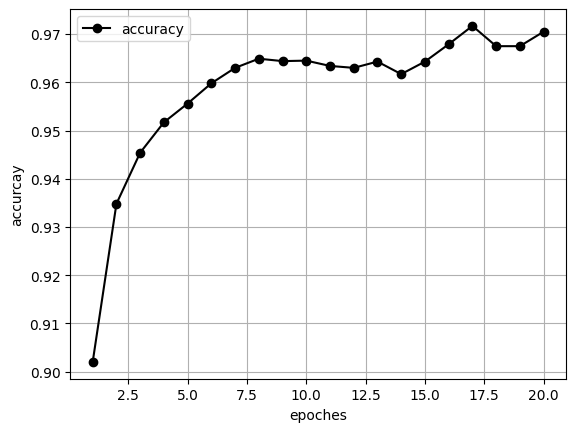

In [ ]:
epoches = [x for x in range(1,21)]
plt.plot(epoches,k,'ko-',label ='accuracy')
plt.xlabel('epoches')
plt.ylabel('accurcay')
plt.grid()
plt.legend()


Text(0.5, 0.98, 'Confusion Matrix')

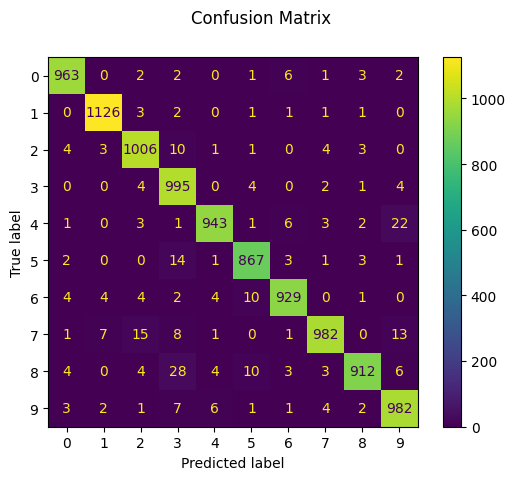

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(actual_label, m)
disp.figure_.suptitle("Confusion Matrix")

In [ ]:
print(classification_report(actual_label,m))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.93      0.99      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.98      0.94      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### observation using ReLu inplace of sigmoid in the hidden layers

1. The accuracy given by relu was spectacular we are getting accuracy upto 97 percent. We can say the test accuracy is too high so clearly model is liitle bit overtrained here.
2. I used the garlot scheme here for the first time. The intiallization schemes has no significant effect on model training in case relu. In baseline model I have found that being using random gaussian intiallization has better accuracy.
3. The model is clear indication of evidence why relu being used as a preffered activation function in hidden layers.

# DNN with tanh

In [ ]:
class DNN4:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

    # number of nodes in each layer
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    hidden_3 = self.sizes[3]
    output_layer=self.sizes[4]

    # Glorot Initialization
    self.params = {
        'W1':np.random.uniform(-0.06,0.06,(hidden_1, input_layer)),
        'W2':np.random.uniform(-0.08,0.08,(hidden_2, hidden_1)),
        'W3':np.random.uniform(-0.13,0.13,(hidden_3, hidden_2)),
        'W4':np.random.uniform(-0.23,0.23,(output_layer,hidden_3))
    }

  def sigmoid(self, x, derivative=False):
      if derivative:
          return (np.exp(-x))/((np.exp(-x)+1)**2)
      return 1/(1 + np.exp(-x))

  def relu(self,x,derivative = False):
      if derivative:
         return np.where(x > 0, 1, 0)
      return np.maximum(0,x)

  def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)

  def tanh(self,x,derivative = False):
      if derivative:
          return 1 - np.tanh(x)**2
      return np.tanh(x)

  def forward_pass(self, x_train):
      params = self.params

      # input layer activations becomes sample
      params['A0'] = x_train

      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.tanh(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.tanh(params['Z2'])

      # hidden layer 2 to hidden layer 3
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.tanh(params['Z3'])

      # hidden layer 3 to output layer

      params['Z4'] = np.dot(params["W4"], params['A3'])
      params['A4'] = self.softmax(params['Z4'])

      return params['A4']
  def backward_pass(self, y_train, output):
      '''
          This is the backpropagation algorithm, for calculating the updates
          of the neural network's parameters.

          Note: There is a stability issue that causes warnings. This is
                caused  by the dot and multiply operations on the huge arrays.

                RuntimeWarning: invalid value encountered in true_divide
                RuntimeWarning: overflow encountered in exp
                RuntimeWarning: overflow encountered in square
      '''
      params = self.params
      change_w = {}

      # Calculate W4 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z4'], derivative=True)
      change_w['W4'] = np.outer(error, params['A3'])

      # Calculate W3 update
      error = np.dot(params['W4'].T, error) * self.tanh(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.tanh(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.tanh(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w
  def update_network_parameters(self, changes_to_w):
      '''
          Update network parameters according to update rule from
          Stochastic Gradient Descent.

          θ = θ - η * ∇J(x, y),
              theta θ:            a network parameter (e.g. a weight w)
              eta η:              the learning rate
              gradient ∇J(x, y):  the gradient of the objective function,
                                  i.e. the change for a specific theta θ
      '''

      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value
  def compute_accuracy(self, test_data, output_nodes):
      '''
          This function does a forward pass of x, then checks if the indices
          of the maximum value in the output equals the indices in the label
          y. Then it sums over each prediction and calculates the accuracy.
      '''
      predictions = []
      all_predictions = []


      for x in test_data:
          all_values = x.split(',')
          # scale and shift the inputs
          inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
          # create the target output values (all 0.01, except the desired label which is 0.99)
          targets = np.zeros(output_nodes) + 0.01
          # all_values[0] is the target label for this record
          targets[int(all_values[0])] = 0.99
          output = self.forward_pass(inputs)
          pred = np.argmax(output)
          predictions.append(pred == np.argmax(targets))
          all_predictions.append(pred)

      return np.mean(predictions),all_predictions
  def train(self, train_list, test_list, output_nodes):
        acc = []
        pred_for =[]
        start_time = time.time()
        for iteration in range(self.epochs):
          for x in train_list:
              all_values = x.split(',')
              # scale and shift the inputs
              inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
              # create the target output values (all 0.01, except the desired label which is 0.99)
              targets = np.zeros(output_nodes) + 0.01
              # all_values[0] is the target label for this record
              targets[int(all_values[0])] = 0.99
              output = self.forward_pass(inputs)
              changes_to_w = self.backward_pass(targets, output)
              self.update_network_parameters(changes_to_w)

          accuracy, _ = self.compute_accuracy(test_list, output_nodes)

          acc.append(accuracy)
          print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
              iteration+1, time.time() - start_time, accuracy * 100
          ))
        _,all_pred = self.compute_accuracy(test_list,output_nodes)
        pred_for.extend(all_pred)
        return acc,pred_for


In [ ]:
dnn = DNN4(sizes=[784, 500, 250,100,10], epochs=15, lr=0.01)
acc_tan,pred_tan=dnn.train(train_list, test_list, 10)

Epoch: 1, Time Spent: 187.64s, Accuracy: 91.38%
Epoch: 2, Time Spent: 362.30s, Accuracy: 92.91%
Epoch: 3, Time Spent: 543.63s, Accuracy: 93.72%
Epoch: 4, Time Spent: 725.25s, Accuracy: 94.25%
Epoch: 5, Time Spent: 906.04s, Accuracy: 94.62%
Epoch: 6, Time Spent: 1085.68s, Accuracy: 95.00%
Epoch: 7, Time Spent: 1265.59s, Accuracy: 95.45%
Epoch: 8, Time Spent: 1443.97s, Accuracy: 95.71%
Epoch: 9, Time Spent: 1622.92s, Accuracy: 95.89%
Epoch: 10, Time Spent: 1803.19s, Accuracy: 96.02%
Epoch: 11, Time Spent: 1981.16s, Accuracy: 96.18%
Epoch: 12, Time Spent: 2159.44s, Accuracy: 96.31%
Epoch: 13, Time Spent: 2338.66s, Accuracy: 96.42%
Epoch: 14, Time Spent: 2519.42s, Accuracy: 96.45%
Epoch: 15, Time Spent: 2698.07s, Accuracy: 96.60%


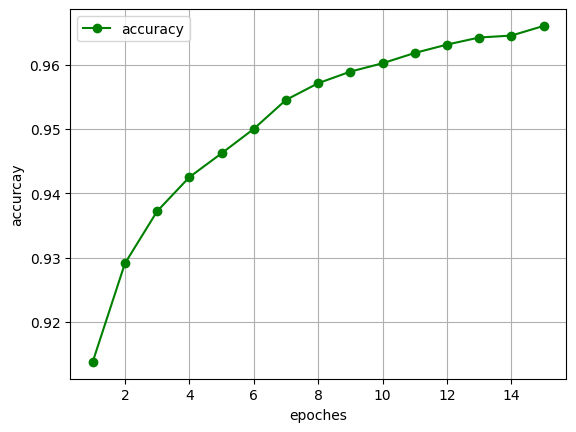

In [ ]:
epoches = [x for x in range(1,16)]
plt.plot(epoches,acc_tan,'go-',label ='accuracy')
plt.xlabel('epoches')
plt.ylabel('accurcay')
plt.grid()
plt.legend()

Text(0.5, 0.98, 'Confusion Matrix')

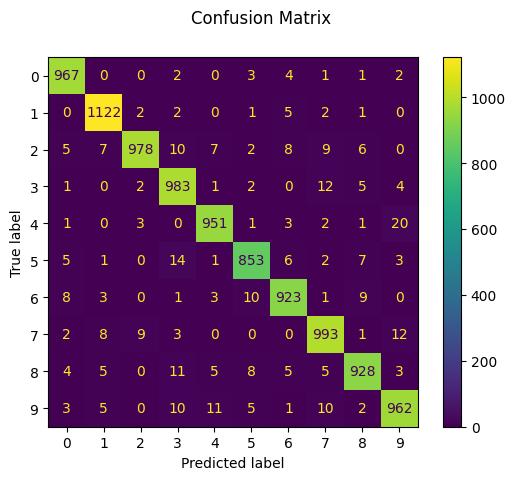

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(actual_label, pred_tan)
disp.figure_.suptitle("Confusion Matrix")

In [ ]:
print(classification_report(actual_label,pred_tan))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.95      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.96      0.96       892
           6       0.97      0.96      0.96       958
           7       0.96      0.97      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Observations for tanh
1. The accuracy is as par with the relu
2. The glorot intiallization is used in this model
